In [1]:
using GraphPPL, ReactiveMP, Distributions
using Plots

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1662


In [2]:
# Generate toy dataset
T = 15
x_0_data = 0.6
a_data = 1.2

x_data = Vector{Float64}(undef, T)
y_data = Vector{Float64}(undef, T)

x_t_min_data = x_0_data
for t=1:T
    x_data[t] = a_data*x_t_min_data
    y_data[t] = ceil(x_data[t])
    
    x_t_min_data = x_data[t]
end    
;

In [3]:
# Specify forward transition
f(x_t_min::Float64, a::Float64) = a*x_t_min


@model function NKS(n)
    o = datavar(Float64, n)
    z = randomvar(n)
    a = randomvar(n)

    z_0 ~ Normal(μ=0.0, γ=1.0)
    z_prev = z_0
    for i in 1:n
        a[i] ~ Normal(μ=1.0, γ=2.0)
        z[i] ~ f(z_prev, a[i]) where {meta=UT()}
        o[i] ~ Normal(μ=z[i], σ²=0.2)

        z_prev = z[i]
    end
end

In [4]:
imarginals = (z_0 = MvNormal(zeros(2), diageye(2)), )
n = length(y_data)
result = inference(model = Model(NKS, n), data=(o=y_data,), free_energy=false);

"called marginal" = "called marginal"
(μ_in, Σ_in) = mean_cov(q_ins) = ([8.004174031576499, 1.2481783026629607], [10.0406171356769 39.959262791877606; 39.959262791877606 321.34853658074485])
"called marginal" = "called marginal"
(μ_in, Σ_in) = mean_cov(q_ins) = ([6.997053779840293, 1.1441029022073625], [5.114224414397199 0.4121934784689934; 0.4121934784689934 4.88077750898616])
"called marginal" = "called marginal"
(μ_in, Σ_in) = mean_cov(q_ins) = ([5.994990967779304, 1.1674577918276294], [5.21980210680976 0.8394734907950042; 0.8394734907950042 7.023386234245131])
"called marginal" = "called marginal"
(μ_in, Σ_in) = mean_cov(q_ins) = ([4.991958108692985, 1.2015683953928227], [5.234146151786277 0.5576414889437188; 0.5576414889437188 4.774902960948494])
"called marginal" = "called marginal"
(μ_in, Σ_in) = mean_cov(q_ins) = ([4.022655679971806, 1.2423861847262112], [5.193531879613059 0.275811075377181; 0.275811075377181 3.1029685769221036])
"called marginal" = "called marginal"
(μ_in, Σ_i

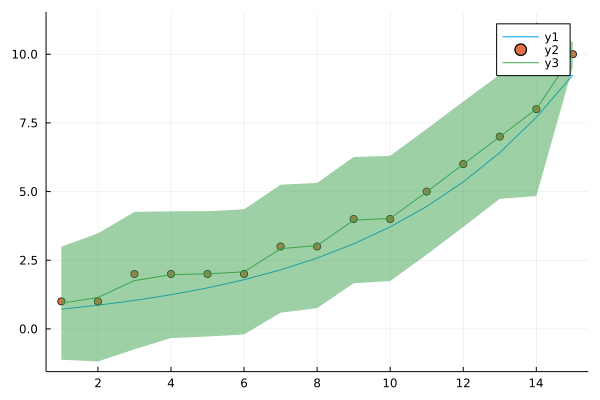

In [5]:

plot(x_data)
scatter!(y_data)
plot!(mean.(result.posteriors[:z]), ribbon=sqrt.(var.(result.posteriors[:z])))

### ET

In [6]:
function f(x)
    return sqrt.(x)
end

function f_inv(x)
    return x .^ 2
end


@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    x ~ MvNormal(μ=ones(2), Λ=diageye(2))
    z ~ f(x) where {meta=ET(inverse=f_inv)}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [7]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=4.0,), free_energy=false)

Inference results:
-----------------------------------------
y1 = NormalWeightedMeanPrecision{Float64}(xi=8.8, w=2.8)
x  = MvNormalWeightedMeanPrecision(
xi: [1.1666666666669165, 1.0]
Λ: [1.0104166666667...


In [8]:
mean(result.posteriors[:x])

2-element Vector{Float64}:
 1.1546391752579255
 0.4999999999999999

In [9]:
function f(x)
    return sqrt.(x)
end


@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    x ~ MvNormal(μ=ones(2), Λ=diageye(2))
    z ~ f(x) where {meta=ET()}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [10]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

m_ins = (MvNormalMeanPrecision(
μ: [1.0, 1.0]
Λ: [1.0 0.0; 0.0 1.0]
)
,)
(A, b) = ([0.5 0.0; 0.0 0.5], [0.5, 0.5])
μ_fw_out = [1.0, 1.0]


Inference results:
-----------------------------------------
y1 = NormalWeightedMeanPrecision{Float64}(xi=2.8, w=2.8)
x  = MvNormalWeightedMeanPrecision(
xi: [1.1666666666664167, 0.99999999999975]
Λ: [1....


In [11]:
mean(result.posteriors[:x])

2-element Vector{Float64}:
 0.9999999999995713
 0.9999999999995

In [12]:
function f(x, θ)
    return x .+ θ
end

function f_x(θ, z)
    return z .- θ
end

function f_θ(x, z)
    return z .- x
end

c = randn(2);

@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    θ ~ MvNormal(μ=ones(2), Λ=diageye(2))
    x ~ MvNormal(μ=zeros(2), Λ=diageye(2))
    z ~ f(x, θ) where {meta=ET(inverse=(f_x, f_θ))}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [14]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

LoadError: RuleMethodError: no method matching rule for the given arguments

Possible fix, define:

@rule DeltaFn{f}(:(:in, k), Marginalisation) (m_out::MvNormalWeightedMeanPrecision, m_ins::Tuple, meta::DeltaExtended{Tuple{typeof(f_x), typeof(f_θ)}}) = begin 
    return ...
end



In [16]:
function f(x, θ, ζ)
    return x .+ θ .+ ζ
end


@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    θ ~ MvNormal(μ=ones(2), Λ=diageye(2))
    ζ ~ MvNormal(μ=0.5ones(2), Λ=diageye(2))
    x ~ MvNormal(μ=zeros(2), Λ=diageye(2))
    z ~ f(x, θ, ζ) where {meta=ET()}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [17]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

Inference results:
-----------------------------------------
y1 = NormalWeightedMeanPrecision{Float64}(xi=2.375, w=2.25)
ζ  = MvNormalWeightedMeanPrecision(
xi: [0.4999999999995714, 0.49999999999900013]
Λ: ...
θ  = MvNormalWeightedMeanPrecision(
xi: [1.1428571428568057, 0.9999999999995002]
Λ: [...
x  = MvNormalWeightedMeanPrecision(
xi: [-0.14285714285766313, -1.499911306270087e-12...


### UT

In [18]:
function f(x)
    return x
end

function f_inv(x)
    return x
end

c = randn(2);

@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    # γ ~ Gamma(α=1.0, β=1.0)
    x ~ MvNormal(μ=zeros(2), Λ=diageye(2))
    z ~ f(x) where {meta=UT(inverse=f_inv)}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [19]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

(μ_tilde, Σ_tilde, _) = unscentedStatistics(μ_fw_in1, Σ_fw_in1, f; alpha = meta.alpha, beta = meta.beta, kappa = meta.kappa) = ([0.0, 0.0], [1.0 0.0; 0.0 1.0], [1.0 0.0; 0.0 1.0])


Inference results:
-----------------------------------------
y1 = NormalWeightedMeanPrecision{Float64}(xi=2.0, w=2.5)
x  = MvNormalWeightedMeanPrecision(
xi: [0.6666666666676693, 0.0]
Λ: [1.6666666666676...


In [20]:
function f(x)
    return x.^2
end

c = randn(2);

@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    x ~ MvNormal(μ=zeros(2), Λ=diageye(2))
    z ~ f(x) where {meta=UT()}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [21]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

(μ_tilde, Σ_tilde, _) = unscentedStatistics(μ_fw_in1, Σ_fw_in1, f; alpha = meta.alpha, beta = meta.beta, kappa = meta.kappa) = ([1.0, 1.0], [2.000001000065822 1.9999990000505932; 1.9999990000505932 2.000001000065822], [0.0 0.0; 0.0 0.0])
(μ_tilde, Σ_tilde, C_tilde) = ([1.0, 1.0], [2.000001000065822 1.9999990000505932; 1.9999990000505932 2.000001000065822], [0.0 0.0; 0.0 0.0])
(μ_in, Σ_in) = ([0.0, 0.0], [1.0 0.0; 0.0 1.0])
(μ_in, Σ_in) = mean_cov(q_ins) = ([0.0, 0.0], [1.0 -0.0; -0.0 1.0])


Inference results:
-----------------------------------------
y1 = NormalWeightedMeanPrecision{Float64}(xi=2.3333332222149457, w=2.3333332222149457...
x  = MvNormalWeightedMeanPrecision(
xi: [0.0, 0.0]
Λ: [1.0 0.0; 0.0 1.0]
)



In [22]:
function f(x, θ)
    return x .+ θ
end

function f_x(θ, z)
    return z .- θ
end

function f_θ(x, z)
    return z .- x
end

c = randn(2);

@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    θ ~ MvNormal(μ=ones(2), Λ=diageye(2))
    x ~ MvNormal(μ=zeros(2), Λ=diageye(2))
    z ~ f(x, θ) where {meta=UT(inverse=(f_x, f_θ))}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [23]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

LoadError: RuleMethodError: no method matching rule for the given arguments

Possible fix, define:

@rule DeltaFn{f}(:(:in, k), Marginalisation) (m_out::MvNormalWeightedMeanPrecision, m_ins::Tuple, meta::DeltaUnscented{Tuple{typeof(f_x), typeof(f_θ)}}) = begin 
    return ...
end



In [24]:
function f(x, θ)
    return x .+ θ
end

c = randn(2);

@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    θ ~ MvNormal(μ=ones(2), Λ=diageye(2))
    # ζ ~ MvNormal(μ=0.5ones(2), Λ=diageye(2))
    x ~ MvNormal(μ=zeros(2), Λ=diageye(2))
    z ~ f(x, θ) where {meta=UT()}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [25]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

"called marginal" = "called marginal"
(μ_in, Σ_in) = mean_cov(q_ins) = ([-1.705935392948323e-11, -9.999778782799056e-13, 0.9999999999829406, 0.999999999999], [1.6666666666676055 -1.2503668776828297e-32 0.6666666666675873 5.382188518894395e-22; -1.2503668776828297e-32 1.000000000001 -1.1494886002502958e-32 9.999778782818784e-13; 0.6666666666675873 -1.1494886002502958e-32 1.666666666667569 5.382188518904331e-22; 5.382188518894395e-22 9.999778782818784e-13 5.382188518904331e-22 1.000000000001])
(μ_in, Σ_in) = mean_cov(q_ins) = ([-1.705935392948323e-11, -9.999778782799056e-13, 0.9999999999829406, 0.999999999999], [1.6666666666676055 -1.2503668776828297e-32 0.6666666666675873 5.382188518894395e-22; -1.2503668776828297e-32 1.000000000001 -1.1494886002502958e-32 9.999778782818784e-13; 0.6666666666675873 -1.1494886002502958e-32 1.666666666667569 5.382188518904331e-22; 5.382188518894395e-22 9.999778782818784e-13 5.382188518904331e-22 1.000000000001])


Inference results:
-----------------------------------------
y1 = NormalWeightedMeanPrecision{Float64}(xi=2.333333333352748, w=2.3333333333333455)...
θ  = MvNormalWeightedMeanPrecision(
xi: [0.5999999999894395, 0.9999999999979999]
Λ: [...
x  = MvNormalWeightedMeanPrecision(
xi: [-1.023561235768417e-11, -9.999778782789055e-...
